In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from cnn import *
from lstm import *
from utils import *

device = torch.device("cpu")

MODEL TESTING

corpus

In [2]:
print('్' + 'క') 

్క


In [3]:
acchulu = ['అ', 'ఆ', 'ఇ', 'ఈ', 'ఉ', 'ఊ', 'ఋ', 'ౠ', 'ఌ', 'ౡ', 'ఎ', 'ఏ', 'ఐ', 'ఒ', 'ఓ', 'ఔ', 'అం', 'అః']
hallulu = ['క', 'ఖ', 'గ', 'ఘ', 'ఙ',
           'చ', 'ఛ', 'జ', 'ఝ', 'ఞ',
           'ట', 'ఠ', 'డ', 'ఢ', 'ణ',
           'త', 'థ', 'ద', 'ధ', 'న',
           'ప', 'ఫ', 'బ', 'భ', 'మ',
           'య', 'ర', 'ల', 'వ', 'శ', 'ష', 'స', 'హ', 'ళ', 'క్ష', 'ఱ']
vallulu = ['ా', 'ి', 'ీ', 'ు' , 'ూ', 'ృ', 'ౄ', 'ె', 'ే', 'ై', 'ొ', 'ో', 'ౌ', 'ం', 'ః', 'ఁ', 'ౕ', 'ౖ', 'ౢ' ]
connector = ['్']
numbers = ['౦', '౧', '౨', '౩', '౪', '౫', '౬', '౭', '౮', '౯']
splcharacters= [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')',
              '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[',
              '\\', ']', '^', '_', '`', '{', '|', '}', '~', '1','2', '3', '4', '5', '6', '7', '8', '9', '0', 'ఽ']
spl = splcharacters + numbers

bases = acchulu + hallulu + spl
vms = vallulu
cms = hallulu

print("Bases: ", len(bases))
print("Vms: ", len(vms))
print("Cms: ", len(cms))

characters = bases+vms+cms+connector

base_mapping = {}
i = 2
for x in bases:
  base_mapping[x] = i
  i+=1

vm_mapping = {}
i = 2
for x in vms:
  vm_mapping[x] = i
  i+=1

cm_mapping = {}
i = 2
for x in cms:
  cm_mapping[x] = i
  i+=1

  
# creates a list of ductionaries with each dictionary reporesenting a term
def wordsDicts(s):
  List = []
  for i in range(len(s)):
    x = s[i]
    prev = ''
    if i > 0: prev = s[i-1]
    #----------------------------------is it a base term-----------------------
    if((x in acchulu or x in hallulu)  and prev != connector[0]):
      List.append({})
      List[-1]['base'] = x
    #----------------------------if it is a consonant modifier-----------------
    elif x in hallulu and prev == connector[0]:
      if(len(List) == 0):
        print(x)
      if('cm' not in List[-1]): List[-1]['cm'] = []
      List[len(List)-1]['cm'].append(x)

      #---------------------------if it is a vowel modifier--------------------
    elif x in vallulu:
      if(len(List) == 0):
        print(x)

      if('vm' not in List[-1]): List[-1]['vm'] = []
      List[len(List)-1]['vm'].append(x)

      #----------------------------it is a spl character-----------------------
    elif x in spl:
      List.append({})
      List[len(List)-1]['base'] = x
    else:
      continue
  return List

Bases:  108
Vms:  19
Cms:  36


index encoding

In [4]:
def index_encoding(s):
  List = wordsDicts(s)
  onehot = []
  for i in range(len(List)):
    D = List[i]
    onehotbase=  [1]
    onehotvm1 =  [1]
    onehotvm2 =  [1]
    onehotvm3 =  [1]
    onehotvm4 =  [1]
    onehotcm1 =  [1]
    onehotcm2 =  [1]
    onehotcm3 =  [1]
    onehotcm4 =  [1]


    onehotbase[0] = base_mapping[D['base']]

    it = 1
    if('vm' in D):
      for j in D['vm']:
        if it == 1:
          onehotvm1[0] = vm_mapping[j]
        elif it == 2:
          onehotvm2[0] = vm_mapping[j]
        elif it == 3:
          onehotvm3[0] = vm_mapping[j]
        elif it == 4:
          onehotvm4[0] = vm_mapping[j]
        it += 1
    
    it = 1
    if('cm' in D):
      for j in D['cm']:
        if it == 1:
          onehotcm1[0] = cm_mapping[j]
        elif it == 2:
          onehotcm2[0] = cm_mapping[j]
        elif it == 3:
          onehotcm3[0] = cm_mapping[j]
        elif it == 4:
          onehotcm4[0] = cm_mapping[j]
        it += 1
    onehoti = onehotbase + onehotvm1 + onehotvm2 + onehotvm3 + onehotvm4 + onehotcm1 + onehotcm2 + onehotcm3 + onehotcm4 #size 110 + 4*21 + 4*38 = 346
    onehot.append(onehoti)
  return onehot

def index_decoder(List):
  x = ""
  for onehoti in List:
    if onehoti[0] > 1:
      x += bases[onehoti[0]-2]

    if onehoti[5] > 1:
      x += connector[0]
      x += cms[onehoti[5]-2]
    if onehoti[6] > 1:
      x += connector[0]
      x += cms[onehoti[6]-2]
    if onehoti[7] > 1:
      x += connector[0]
      x += cms[onehoti[7]-2]
    if onehoti[8] > 1:
      x += connector[0]
      x += cms[onehoti[8]-2]

    if onehoti[1] > 1:
      x += vms[onehoti[1]-2]
    if onehoti[2] > 1:
      x += vms[onehoti[2]-2]
    if onehoti[3] > 1:
      x += vms[onehoti[3]-2]
    if onehoti[4] > 1:
      x += vms[onehoti[4]-2]
  return x

one-hot-encoding

In [5]:
def one_hot_encoder(s):
  List = wordsDicts(s)
  onehot = []
  for i in range(len(List)):
    D = List[i]
    onehotbase=  [0 for _ in range(len(bases) + 2)]
    onehotvm1 =  [0 for _ in range(len(vms) + 2)]
    onehotvm2 =  [0 for _ in range(len(vms) + 2)]
    onehotvm3 =  [0 for _ in range(len(vms) + 2)]
    onehotvm4 =  [0 for _ in range(len(vms) + 2)]

    onehotcm1 =  [0 for _ in range(len(cms) + 2)]   
    onehotcm2 =  [0 for _ in range(len(cms) + 2)]   
    onehotcm3 =  [0 for _ in range(len(cms) + 2)]   
    onehotcm4 =  [0 for _ in range(len(cms) + 2)]   

    onehotbase[base_mapping[D['base']]] = 1

    it = 1
    if('vm' in D):
      for j in D['vm']:
        if it == 1:
          onehotvm1[vm_mapping[j]] = 1
        elif it == 2:
          onehotvm2[vm_mapping[j]] = 1
        elif it == 3:
          onehotvm3[vm_mapping[j]] = 1
        elif it == 4:
          onehotvm4[vm_mapping[j]] = 1
        it += 1
    
    it = 1
    if('cm' in D):
      for j in D['cm']:
        if it == 1:
          onehotcm1[cm_mapping[j]] = 1
        elif it == 2:
          onehotcm2[cm_mapping[j]] = 1
        elif it == 3:
          onehotcm3[cm_mapping[j]] = 1
        elif it == 4:
          onehotcm4[cm_mapping[j]] = 1
        it += 1


    onehoti = onehotbase + onehotvm1 + onehotvm2 + onehotvm3 + onehotvm4 + onehotcm1 + onehotcm2 + onehotcm3 + onehotcm4 #size 110 + 4*21 + 4*38 = 346
    onehot.append(onehoti)
  encoded = torch.tensor(onehot).float().to(device)
  return encoded

def One_Hot_Decoder(List):
  x = ""
  for onehoti in List:
    for i in range(0, 110):
      if onehoti[i] == 1 and i > 1:
          x += bases[i-2]

    for i in range(194, 232):
      if onehoti[i] == 1 and i > 195:
        x += connector[0]
        x += cms[i-196]
    for i in range(232, 270):
      if onehoti[i] == 1 and i > 233:
        x += connector[0]
        x += cms[i-234]
    for i in range(270, 308):
      if onehoti[i] == 1 and i > 271:
        x += connector[0]
        x += cms[i-272]
    for i in range(308, 346):
      if onehoti[i] == 1 and i > 309:
        x += connector[0]
        x += cms[i-310]

    for i in range(110, 131):
      if onehoti[i] == 1 and i > 111:
        x += vms[i-112]
    for i in range(131, 152):
      if onehoti[i] == 1 and i > 132:
        x += vms[i-133]
    for i in range(152, 173):
      if onehoti[i] == 1 and i > 153:
        x += vms[i-154]
    for i in range(173, 194):
      if onehoti[i] == 1 and i > 174:
        x += vms[i-175]
  return x

In [6]:
s = "అందరికి నమస్కారం"
print(s)
print(index_decoder(index_encoding(s)))
print(One_Hot_Decoder(one_hot_encoder(s)))

అందరికి నమస్కారం
అందరికి నమస్కారం
అందరికి నమస్కారం


In [11]:
Max = 0
for file_num in range(1, 41):
    label_lengths = torch.load("/home/ocr/teluguOCR/Dataset/Full_label_length_tensors/Full_Label_Lengths"+ str(file_num) + ".pt")
    Max = max(Max, max(label_lengths))
print(Max)

tensor(40)


tensor(29)


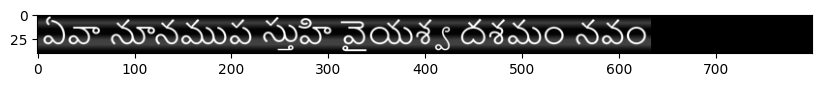

actual label:  ఏవా నూనముప స్తుహి వైయశ్వ దశమం నవం


In [10]:
# cnn = EncoderCNN().to(device)
# rnn = LSTM_NET().to(device)

# cnn.load_state_dict(torch.load("/home/ocr/teluguOCR/Models/CNN/Model13.pth"))
# rnn.load_state_dict(torch.load("/home/ocr/teluguOCR/Models/RNN/Model13.pth"))

# cnn.eval()
# rnn.eval()

file_num = 10
image_num = 1

image = torch.load("/home/ocr/teluguOCR/Dataset/Full_Image_Tensors/Full_Image_Tensors"+ str(file_num) + ".pt")[image_num-1:image_num]
label = torch.load("/home/ocr/teluguOCR/Dataset/Full_Label_Tensors/Full_Label_Tensors"+ str(file_num) + ".pt")[image_num-1:image_num]

plt.figure(figsize=(10,10))
plt.imshow(image.squeeze(0).squeeze(0).cpu(), cmap='gray')
plt.show()

label = label.squeeze(0).cpu().to(torch.int64).numpy()

print("actual label: ", index_decoder(label))

# image = image.to(device)

# cnn_output = cnn(image).unsqueeze(1)


# f_output = torch.zeros(Image_length, 1, Text_embedding_size).to(device)
# for k in range(Image_length):
#     f_output[k, : , :] = rnn(cnn_output[:, :, k, :], k == 0).squeeze(1)

# f_output_sm = torch.zeros(Image_length, 1, 346).to(device)

# f_output_sm[:, :, 0:110] = F.softmax(f_output[:, :, 0:110], dim=2)
# f_output_sm[:, :, 110:131] = F.softmax(f_output[:, :, 110:131], dim=2)
# f_output_sm[:, :, 131:152] = F.softmax(f_output[:, :, 131:152], dim=2)
# f_output_sm[:, :, 152:173] = F.softmax(f_output[:, :, 152:173], dim=2)
# f_output_sm[:, :, 173:194] = F.softmax(f_output[:, :, 173:194], dim=2)
# f_output_sm[:, :, 194:232] = F.softmax(f_output[:, :, 194:232], dim=2)
# f_output_sm[:, :, 232:270] = F.softmax(f_output[:, :, 232:270], dim=2)
# f_output_sm[:, :, 270:308] = F.softmax(f_output[:, :, 270:308], dim=2)
# f_output_sm[:, :, 308:346] = F.softmax(f_output[:, :, 308:346], dim=2)

# f_output_sm = f_output_sm.squeeze(1)

# final_label = torch.zeros(Image_length, Text_embedding_size).to(device)

# for i in range(Image_length):
#     final_label[i, torch.argmax(f_output_sm[i, :110])] = 1
#     final_label[i, torch.argmax(f_output_sm[i, 110:131])+110] = 1
#     final_label[i, torch.argmax(f_output_sm[i, 131:152])+131] = 1
#     final_label[i, torch.argmax(f_output_sm[i, 152:173])+152] = 1
#     final_label[i, torch.argmax(f_output_sm[i, 173:194])+173] = 1
#     final_label[i, torch.argmax(f_output_sm[i, 194:232])+194] = 1
#     final_label[i, torch.argmax(f_output_sm[i, 232:270])+232] = 1
#     final_label[i, torch.argmax(f_output_sm[i, 270:308])+270] = 1
#     final_label[i, torch.argmax(f_output_sm[i, 308:346])+308] = 1

# print("predicted label: ", One_Hot_Decoder(final_label))

In [ ]:
def One_Hot_Decoder_Only_Base(List):
  x = ""
  for onehoti in List:
    if onehoti[0] == 1:
      x += '_'
      continue
    for i in range(0, 110):
      if onehoti[i] == 1 and i > 1:
          x += bases[i-2]
  return x

def One_Hot_Decoder_Only_Vm1(List):
  x = ""
  for onehoti in List:
    if onehoti[110] == 1:
      x += '_'
      continue
    if onehoti[111] == 1:
      x += ' '
      continue
    for i in range(110, 131):
      if onehoti[i] == 1 and i > 111:
        x += vms[i-112]
  return x

def One_Hot_Decoder_Only_Vm2(List):
  x = ""
  for onehoti in List:
    if onehoti[131] == 1:
      x += '_'
      continue
    if onehoti[132] == 1:
      x += ' '
      continue
    for i in range(131, 152):
      if onehoti[i] == 1 and i > 132:
        x += vms[i-133]
  return x

def One_Hot_Decoder_Only_Vm3(List):
  x = ""
  for onehoti in List:
    if onehoti[152] == 1:
      x += '_'
      continue
    if onehoti[153] == 1:
      x += ' '
      continue
    for i in range(152, 173):
      if onehoti[i] == 1 and i > 153:
        x += vms[i-154]
  return x

def One_Hot_Decoder_Only_Vm4(List):
  x = ""
  for onehoti in List:
    if onehoti[173] == 1:
      x += '_'
      continue
    if onehoti[174] == 1:
      x += ' '
      continue
    for i in range(173, 194):
      if onehoti[i] == 1 and i > 174:
        x += vms[i-175]
  return x

def One_Hot_Decoder_Only_Cm1(List):
  x = ""
  for onehoti in List:
    if onehoti[194] == 1:
      x += '_'
      continue
    if onehoti[195] == 1:
      x += ' '
      continue
    for i in range(194, 232):
      if onehoti[i] == 1 and i > 195:
        x += connector[0]
        x += cms[i-196]
  return x

def One_Hot_Decoder_Only_Cm2(List):
  x = ""
  for onehoti in List:
    if onehoti[232] == 1:
      x += '_'
      continue
    if onehoti[233] == 1:
      x += ' '
      continue
    for i in range(232, 270):
      if onehoti[i] == 1 and i > 233:
        x += connector[0]
        x += cms[i-234]
  return x

def One_Hot_Decoder_Only_Cm3(List):
  x = ""
  for onehoti in List:
    if onehoti[270] == 1:
      x += '_'
      continue
    if onehoti[271] == 1:
      x += ' '
      continue
    for i in range(270, 308):
      if onehoti[i] == 1 and i > 271:
        x += connector[0]
        x += cms[i-272]
  return x

def One_Hot_Decoder_Only_Cm4(List):
  x = ""
  for onehoti in List:
    if onehoti[308] == 1:
      x += '_'
      continue
    if onehoti[309] == 1:
      x += ' '
      continue
    for i in range(308, 346):
      if onehoti[i] == 1 and i > 309:
        x += connector[0]
        x += cms[i-310]
  return x



def index_decoder_Only_Base(List):
  x = ""
  for onehoti in List:
    if onehoti[0] > 1:
      x += bases[onehoti[0]-2]
  return x

print("actual label: ", index_decoder(label))

for i in range(100):
    if(final_label[i][0] == 1):
        print('_', end = '')
    else:
        print(One_Hot_Decoder_Only_Base(final_label[i][:110].unsqueeze(0)), end = '')
print()

base = []
vm1 = []
vm2 = []
vm3 = []
vm4 = []
cm1 = []
cm2 = []
cm3 = []
cm4 = []

for i in range(100):
    base.append(One_Hot_Decoder_Only_Base(final_label[i].unsqueeze(0)))
    vm1.append(One_Hot_Decoder_Only_Vm1(final_label[i].unsqueeze(0)))
    vm2.append(One_Hot_Decoder_Only_Vm2(final_label[i].unsqueeze(0)))
    vm3.append(One_Hot_Decoder_Only_Vm3(final_label[i].unsqueeze(0)))
    vm4.append(One_Hot_Decoder_Only_Vm4(final_label[i].unsqueeze(0)))
    cm1.append(One_Hot_Decoder_Only_Cm1(final_label[i].unsqueeze(0)))
    cm2.append(One_Hot_Decoder_Only_Cm2(final_label[i].unsqueeze(0)))
    cm3.append(One_Hot_Decoder_Only_Cm3(final_label[i].unsqueeze(0)))
    cm4.append(One_Hot_Decoder_Only_Cm4(final_label[i].unsqueeze(0)))

print(base)
print(vm1)
print(vm2)
print(vm3)
print(vm4)
print(cm1)
print(cm2)
print(cm3)
print(cm4)

# Removing the continuous duplicate occurances of the same character in the Lists
base = [base[i] for i in range(len(base)) if i == 0 or base[i] != base[i-1]]
vm1 = [vm1[i] for i in range(len(vm1)) if i == 0 or vm1[i] != vm1[i-1]]
vm2 = [vm2[i] for i in range(len(vm2)) if i == 0 or vm2[i] != vm2[i-1]]
vm3 = [vm3[i] for i in range(len(vm3)) if i == 0 or vm3[i] != vm3[i-1]]
vm4 = [vm4[i] for i in range(len(vm4)) if i == 0 or vm4[i] != vm4[i-1]]
cm1 = [cm1[i] for i in range(len(cm1)) if i == 0 or cm1[i] != cm1[i-1]]
cm2 = [cm2[i] for i in range(len(cm2)) if i == 0 or cm2[i] != cm2[i-1]]
cm3 = [cm3[i] for i in range(len(cm3)) if i == 0 or cm3[i] != cm3[i-1]]
cm4 = [cm4[i] for i in range(len(cm4)) if i == 0 or cm4[i] != cm4[i-1]]

# removing all occurances fo '' in the Lists
base = [x for x in base if x != '_']
vm1 = [x for x in vm1 if x != '_']
vm2 = [x for x in vm2 if x != '_']
vm3 = [x for x in vm3 if x != '_']
vm4 = [x for x in vm4 if x != '_']
cm1 = [x for x in cm1 if x != '_']
cm2 = [x for x in cm2 if x != '_']
cm3 = [x for x in cm3 if x != '_']
cm4 = [x for x in cm4 if x != '_']

print(base)
print(vm1)
print(vm2)
print(vm3)
print(vm4)
print(cm1)
print(cm2)
print(cm3)
print(cm4)

x = ""
for i in range(len(base)):
    x += base[i]
    if base[i] == ' ':
      continue

    if i < len(cm1) and  cm1[i] != ' ':
      x += cm1[i]
    if i < len(cm2) and  cm2[i] != ' ':
      x += cm2[i]
    if i < len(cm3) and  cm3[i] != ' ':
      x += cm3[i]
    if i < len(cm4) and  cm4[i] != ' ':
      x += cm4[i]

    if i < len(vm1) and  vm1[i] != ' ':
      x += vm1[i]
    if i < len(vm2) and  vm2[i] != ' ':
      x += vm2[i]
    if i < len(vm3) and  vm3[i] != ' ':
      x += vm3[i]
    if i < len(vm4) and  vm4[i] != ' ':
      x += vm4[i]
      
print("x: ", x)

In [ ]:
f_output_sm = torch.zeros(Image_length, 1, 346).to(device)

f_output_sm[:, :, 0:110] = F.softmax(f_output[:, :, 0:110], dim=2)
f_output_sm[:, :, 110:131] = F.softmax(f_output[:, :, 110:131], dim=2)
f_output_sm[:, :, 131:152] = F.softmax(f_output[:, :, 131:152], dim=2)
f_output_sm[:, :, 152:173] = F.softmax(f_output[:, :, 152:173], dim=2)
f_output_sm[:, :, 173:194] = F.softmax(f_output[:, :, 173:194], dim=2)
f_output_sm[:, :, 194:232] = F.softmax(f_output[:, :, 194:232], dim=2)
f_output_sm[:, :, 232:270] = F.softmax(f_output[:, :, 232:270], dim=2)
f_output_sm[:, :, 270:308] = F.softmax(f_output[:, :, 270:308], dim=2)
f_output_sm[:, :, 308:346] = F.softmax(f_output[:, :, 308:346], dim=2)

f_output_sm = f_output_sm.squeeze(1)
print(f_output_sm.shape)

final_label = torch.zeros(Image_length, Text_embedding_size).to(device)

for i in range(Image_length):
    final_label[i, torch.argmax(f_output_sm[i, :110])] = 1
    final_label[i, torch.argmax(f_output_sm[i, 110:131])+110] = 1
    final_label[i, torch.argmax(f_output_sm[i, 131:152])+131] = 1
    final_label[i, torch.argmax(f_output_sm[i, 152:173])+152] = 1
    final_label[i, torch.argmax(f_output_sm[i, 173:194])+173] = 1
    final_label[i, torch.argmax(f_output_sm[i, 194:232])+194] = 1
    final_label[i, torch.argmax(f_output_sm[i, 232:270])+232] = 1
    final_label[i, torch.argmax(f_output_sm[i, 270:308])+270] = 1
    final_label[i, torch.argmax(f_output_sm[i, 308:346])+308] = 1

print(torch.unique(final_label))

print(One_Hot_Decoder(final_label))

LOSS TESTING

In [ ]:
criterion = nn.CTCLoss(blank=0)

target = torch.tensor([5, 6, 1, 7, 4]).unsqueeze(0)  # 1*5
input = torch.full((100, 1, 11), -0.999, dtype=torch.float64)
input[0, 0, 5] = 0.999
input[1, 0, 0] = 0.999 #
input[2, 0, 0] = 0.999 #
input[3, 0, 0] = 0.999 #
input[4, 0, 6] = 0.999
input[5, 0, 0] = 0.999 #
input[6, 0, 0] = 0.999 #
input[7, 0, 1] = 0.999
input[8, 0, 0] = 0.999 #
input[9, 0, 0] = 0.999 #
input[10, 0, 7] = 0.999
input[11, 0, 0] = 0.999 #
input[12, 0, 4] = 0.999
input[13:, 0, 0] = 0.999 #

input *= 6

input_lengths = torch.full(size=(1,), fill_value=100, dtype=torch.long)
target_lengths = torch.full(size=(1,), fill_value=5, dtype=torch.long)

input = input.log_softmax(2).detach().requires_grad_()

loss = criterion(input, target, input_lengths, target_lengths)
print(loss)

In [ ]:
input_round = torch.round(input)
# print(input_round)
for i in range(100):
    # print(input[i][0])
    if(input_round[i][0][0] == 1): continue
    for j in range(11):
        if(input_round[i][0][j] == 1):
            print(j)
            break